In [126]:
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import random

import os
from torchvision import transforms
from torchvision.datasets import VisionDataset
from PIL import Image
import torch
from torch.utils.data import DataLoader
import numpy as np

import torchvision
import torch.nn as nn
import torch.optim as optim

from torchmetrics.classification import Dice
from torchmetrics.classification import MulticlassF1Score

import torchvision.transforms.functional as F

from collections import defaultdict


## Anzahl vorhandener Bilder

In [2]:
def count_images(folder):
    return len([name for name in os.listdir(folder)])

train_count = count_images('data/train/images')
test_count = count_images('data/test/images')
validation_count = count_images('data/validation/images')

print("Anzahl der Bilder in Train:", train_count)
print("Anzahl der Bilder in Test:", test_count)
print("Anzahl der Bilder in Validation:", validation_count)


Anzahl der Bilder in Train: 1385
Anzahl der Bilder in Test: 199
Anzahl der Bilder in Validation: 396


## Inspektion der Bilder vor einlesen

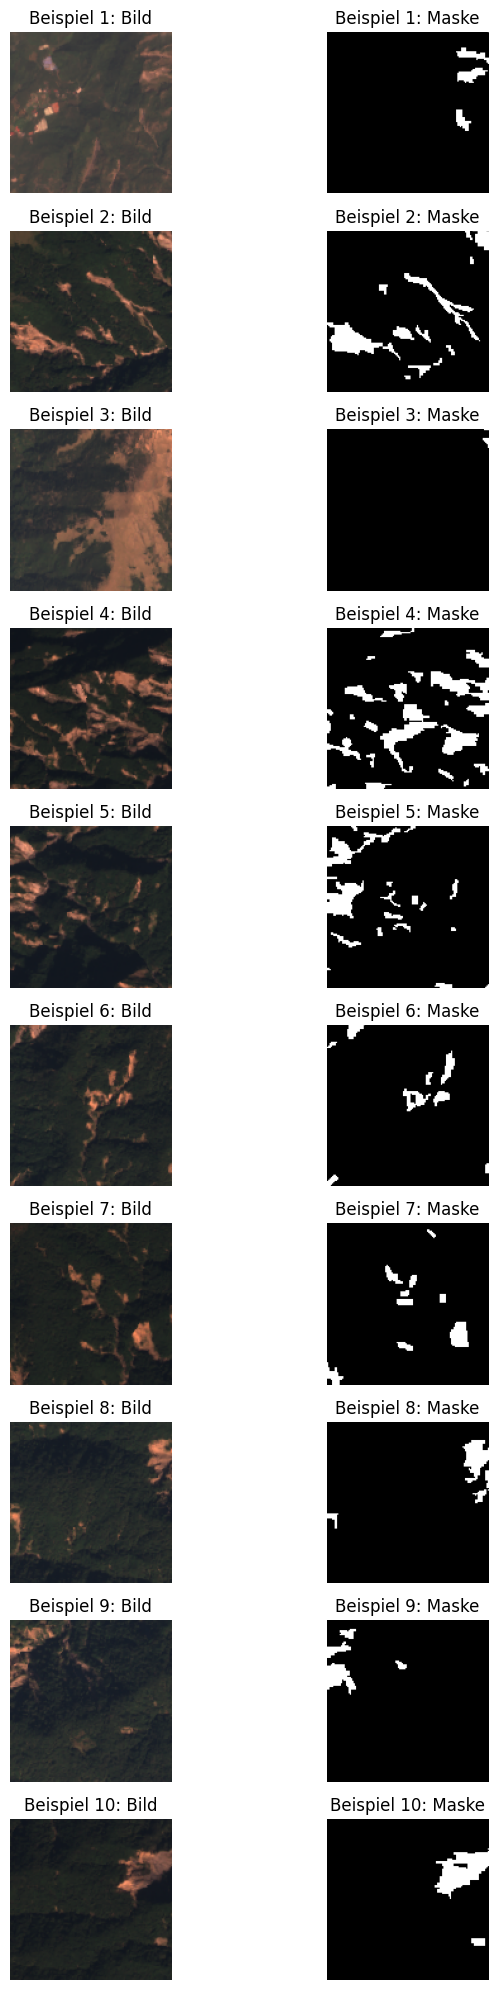

In [3]:
image_dir = 'data/train/images/'
mask_dir = 'data/train/masks/'

# Dateipfade für Bilder und Masken abrufen
image_files = sorted([os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith('.png')])
mask_files = sorted([os.path.join(mask_dir, f) for f in os.listdir(mask_dir) if f.endswith('.png')])

# Sicherstellen, dass Bilder und Masken korrekt zugeordnet sind (z.B. durch gleiche Sortierung)
assert len(image_files) == len(mask_files)

fig, axs = plt.subplots(10, 2, figsize=(8, 20))  # 10 Reihen, 2 Spalten

for i in range(10):
    # Bild
    image = Image.open(image_files[i])
    axs[i, 0].imshow(image)
    axs[i, 0].axis('off')
    axs[i, 0].set_title(f'Beispiel {i + 1}: Bild')

    # Maske
    mask = Image.open(mask_files[i]).convert('L')  # Konvertiere nach Graustufen für konsistente Darstellung
    axs[i, 1].imshow(mask, cmap="gray")
    axs[i, 1].axis('off')
    axs[i, 1].set_title(f'Beispiel {i + 1}: Maske')

plt.tight_layout()
plt.show()

## Überprüfung der Klassen in den Train Masken

In [4]:
value_counter = defaultdict(int)

# Durch alle Masken in der Liste gehen
for mask_path in mask_files:
    # Bild mit PIL laden
    mask = Image.open(mask_path)
    
    # Alle eindeutigen Werte in der Maske zählen
    values, counts = np.unique(np.array(mask), return_counts=True)
    for value, count in zip(values, counts):
        value_counter[value] += count

# Ergebnisse drucken
for value, count in value_counter.items():
    print(f"Wert {value}: {count} Pixel")

Wert 0: 65012958 Pixel
Wert 255: 25754402 Pixel


## Erstellung der Bilderklassen

In [5]:
class SegmentationDataset(VisionDataset):
    def __init__(self, root, split='train', transform_mode='to_tensor'):
        super(SegmentationDataset, self).__init__(root)
        
        assert split in ['train', 'test']
        self.split = split
        self.transform_mode = transform_mode
        
        # Ordnerpfade für Bilder und Masken
        self.images_dir = os.path.join(root, split, 'images')
        self.masks_dir = os.path.join(root, split, 'masks')
        
        # Liste der Dateinamen
        self.images = sorted(os.listdir(self.images_dir))
        self.masks = sorted(os.listdir(self.masks_dir))
        
        assert len(self.images) == len(self.masks)

    def transform_to_tensor(self, image, mask):
        to_tensor = transforms.ToTensor()
        image = to_tensor(image)
        mask = to_tensor(mask)
        return image, mask

    def transform_normalize(self, image, mask):
        to_tensor = transforms.ToTensor()
        # Für die Normalisierung benötigen Sie die mittleren und std-Werte Ihrer Daten.
        # Hier nehme ich an, dass Sie mit den Standardwerten für Imagenet arbeiten.
        normalize = transforms.Normalize(mean=[0,0,0], std=[1,1,1])
        image = normalize(to_tensor(image))
        mask = to_tensor(mask)  # Masken normalisieren wir typischerweise nicht
        return image, mask

    def transform_flip(self, image, mask):
        to_tensor = transforms.ToTensor()
        normalize = transforms.Normalize(mean=[0,0,0], std=[1,1,1])

        if random.random() > 0.5:
                image = F.hflip(image)
                mask = F.hflip(mask)

        image = normalize(to_tensor(image))
        mask = to_tensor(mask)
        return image, mask

    def __getitem__(self, index):
        # Lade das Bild und die entsprechende Maske
        img_path = os.path.join(self.images_dir, self.images[index])
        mask_path = os.path.join(self.masks_dir, self.masks[index])
        
        img = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("1")
             
        if self.transform_mode == 'to_tensor':
            img, mask = self.transform_to_tensor(img, mask)
        elif self.transform_mode == 'normalize':
            img, mask = self.transform_normalize(img, mask)
        elif self.transform_mode == 'flip':
            img, mask = self.transform_flip(img, mask)

        return img, mask

    def __len__(self):
        return len(self.images)


## Einlesen der Bilder für EDA

In [6]:
eda_train_data = SegmentationDataset(root='data', split='train', transform_mode='normalize')
eda_train_loader = DataLoader(eda_train_data, batch_size=64, shuffle=True)

## Inspektion der Bilder nach einlesen

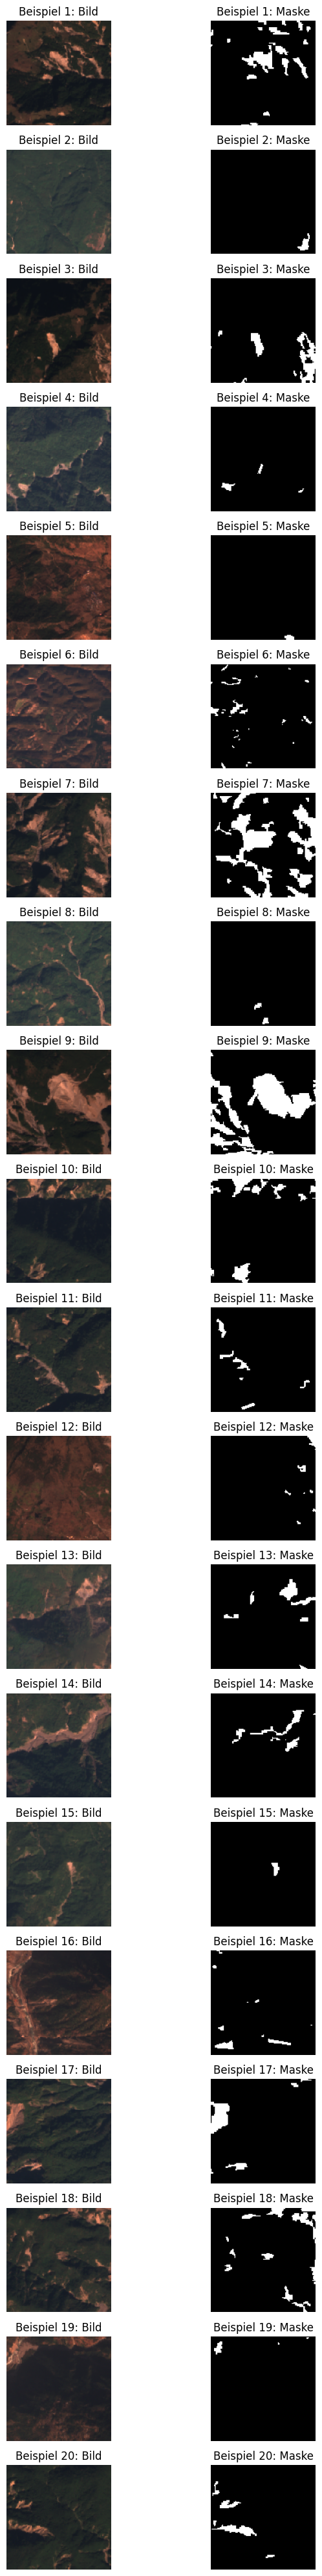

In [7]:
images, masks = next(iter(eda_train_loader))

fig, axs = plt.subplots(20, 2, figsize=(8, 40))  # 10 Reihen, 2 Spalten

for i in range(20):
    # Bild
    image = images[i].numpy().transpose((1, 2, 0))
    axs[i, 0].imshow(image)
    axs[i, 0].axis('off')
    axs[i, 0].set_title(f'Beispiel {i + 1}: Bild')

    # Maske
    mask = masks[i][0].numpy()  # Beachte, dass wir nur den ersten Kanal für die Maske benötigen
    axs[i, 1].imshow(mask, cmap="gray")
    axs[i, 1].axis('off')
    axs[i, 1].set_title(f'Beispiel {i + 1}: Maske')

plt.tight_layout()
plt.show()

## Überprüfung der Bildergrössen

In [8]:
print("Grösser der Bilder:", images.shape)
print("Grösse der Masken:", masks.shape)

Grösser der Bilder: torch.Size([64, 3, 128, 128])
Grösse der Masken: torch.Size([64, 1, 128, 128])


## Verteilung der Klassen in den Train Masken

In [9]:
mask_array = masks[0]

unique_values = np.unique(mask_array)
print("Eindeutige Werte in der Maske:", unique_values)

value_counts = np.bincount(mask_array.flatten())
print("Verteilung der Werte:", value_counts)

Eindeutige Werte in der Maske: [0. 1.]
Verteilung der Werte: [15045  1339]


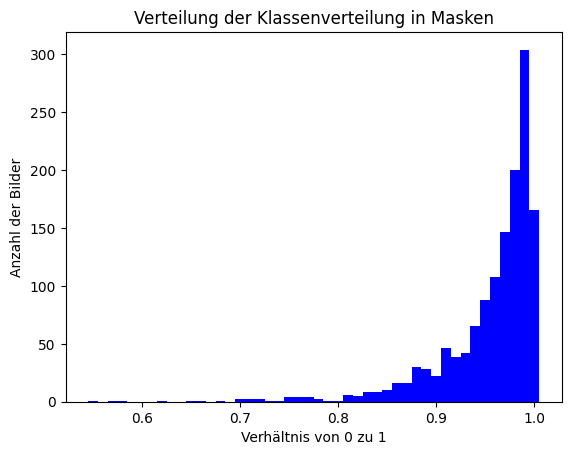

In [10]:
# Code mit ChatGPT erstellt

# Initialisieren Sie den Zähler
ratio_counter = defaultdict(int)

# Berechnen Sie das Verhältnis von 0 zu 1 für jedes Bild
for _, masks in eda_train_loader:
    for mask in masks:
        total_pixels = mask.numel()
        count_1 = torch.sum(mask).item()
        count_0 = total_pixels - count_1
        ratio = round(count_0 / (count_0 + count_1), 2)  # Rundet das Verhältnis auf zwei Dezimalstellen
        ratio_counter[ratio] += 1

# Erstellen Sie ein Histogramm mit matplotlib
ratios = list(ratio_counter.keys())
counts = [ratio_counter[ratio] for ratio in ratios]

plt.bar(ratios, counts, width=0.01, color='blue')
plt.xlabel('Verhältnis von 0 zu 1')
plt.ylabel('Anzahl der Bilder')
plt.title('Verteilung der Klassenverteilung in Masken')
plt.show()

## Verteilung der Farben in den Train Bildern

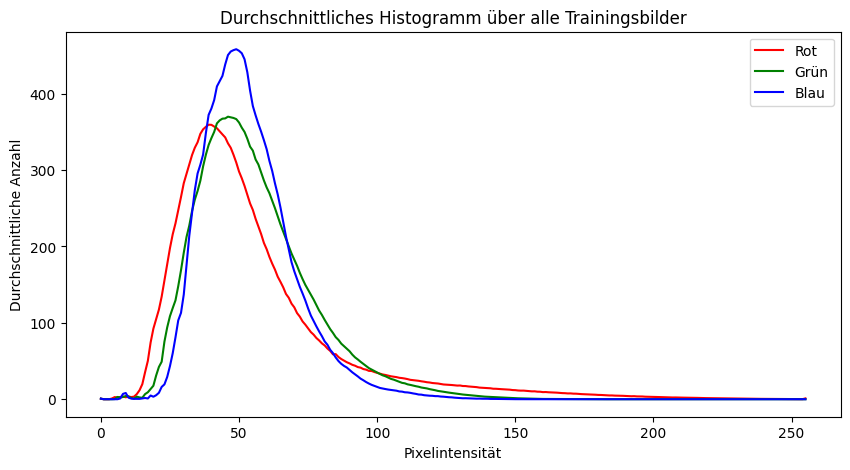

In [11]:
# Code mit ChatGPT erstellt

# Initialisiere Histogramm-Arrays
histogram_red = np.zeros(256)
histogram_green = np.zeros(256)
histogram_blue = np.zeros(256)

for images, _ in eda_train_loader:
    # Versichern Sie sich, dass die Bilder auf der CPU liegen (falls sie auf GPU geladen werden)
    images = images.cpu().numpy()
    
    # Die Form von `images` ist [batch_size, channels, height, width]
    for i in range(images.shape[0]):
        histogram_red += np.histogram(images[i, 0].flatten(), bins=256, range=(0, 1))[0]
        histogram_green += np.histogram(images[i, 1].flatten(), bins=256, range=(0, 1))[0]
        histogram_blue += np.histogram(images[i, 2].flatten(), bins=256, range=(0, 1))[0]

# Mitteln Sie die Histogramme über alle Bilder
num_images = len(eda_train_loader.dataset)
histogram_red /= num_images
histogram_green /= num_images
histogram_blue /= num_images

# Plotte die Histogramme
plt.figure(figsize=(10, 5))
plt.title("Durchschnittliches Histogramm über alle Trainingsbilder")
plt.xlabel("Pixelintensität")
plt.ylabel("Durchschnittliche Anzahl")
plt.plot(histogram_red, color='red', label='Rot')
plt.plot(histogram_green, color='green', label='Grün')
plt.plot(histogram_blue, color='blue', label='Blau')
plt.legend()
plt.show()

In [12]:
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(device)

cuda


In [249]:
model_deeplab = torchvision.models.segmentation.deeplabv3_resnet50(weights=None,num_classes=2)
model_deeplab.to(device)

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

In [239]:
model_unet = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet', in_channels=3, out_channels=2, init_features=2, pretrained=False)
model_unet.to(device)

Using cache found in /users/pschrman/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


UNet(
  (encoder1): Sequential(
    (enc1conv1): Conv2d(3, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc1norm1): BatchNorm2d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc1relu1): ReLU(inplace=True)
    (enc1conv2): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc1norm2): BatchNorm2d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc1relu2): ReLU(inplace=True)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder2): Sequential(
    (enc2conv1): Conv2d(2, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc2norm1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc2relu1): ReLU(inplace=True)
    (enc2conv2): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc2norm2): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_

In [227]:
def train_deeplab(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    train_loss = 0
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        y = y.squeeze(1)
        y = y.long()  

        # Compute prediction error
        pred = model(X)['out']
        loss = loss_fn(pred, y)
        train_loss += loss_fn(pred, y).item()

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss /= num_batches

    return train_loss

In [228]:
def train_unet(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    train_loss = 0
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        
        y = y.squeeze(1)
        y = y.long()  

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)
        train_loss += loss_fn(pred, y).item()

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss /= num_batches

    return train_loss

In [229]:
def test_deeplab(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, dice_value, f1_value = 0, 0, 0

    dice_metric = Dice(num_classes=2, average='macro').to(device)
    f1_score = MulticlassF1Score(num_classes=2, average='none').to(device)

    
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            y = y.squeeze(1)
            y = y.long()  

            pred = model(X)['out']
            test_loss += loss_fn(pred, y).item()

            dice_value += dice_metric(pred, y).item()
            f1_value += f1_score(pred, y)


    test_loss /= num_batches
    dice_value /= num_batches
    f1_value /= num_batches


    return test_loss, dice_value, f1_value.tolist()

In [230]:
def test_unet(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, dice_value, f1_value = 0, 0, 0

    dice_metric = Dice(num_classes=2, average='macro').to(device)
    f1_score = MulticlassF1Score(num_classes=2, average='none').to(device)

    
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            
            y = y.squeeze(1)
            y = y.long()  

            pred = model(X)
            test_loss += loss_fn(pred, y).item()

            dice_value += dice_metric(pred, y.long()).item()
            f1_value += f1_score(pred, y)


    test_loss /= num_batches
    dice_value /= num_batches
    f1_value /= num_batches


    return test_loss, dice_value, f1_value.tolist()

In [231]:
def do_modeltrain_deeplab(epochs, train_dataloader, model, loss_fn, optimizer, test_dataloader):
    for t in range(epochs):
        train_loss = train_deeplab(train_dataloader, model, loss_fn, optimizer)
        print("Training done")
        test_loss, dice, f1_score = test_deeplab(test_dataloader, model, loss_fn)
        
        # Übermittlung der Daten an W&B
        # wandb.log({"accuracy train": accuracy_train, "loss train": train_loss, "accuracy test": accuracy_test, "loss test": test_loss})

        print(t, " Train loss:", train_loss, "Test loss:", test_loss, "Test Dice:", dice, "Test F1:", f1_score)

    print("Done!")

In [232]:
def do_modeltrain_unet(epochs, train_dataloader, model, loss_fn, optimizer, test_dataloader):
    for t in range(epochs):
        train_loss = train_unet(train_dataloader, model, loss_fn, optimizer)
        print("Training done")
        test_loss, dice, f1_score = test_unet(test_dataloader, model, loss_fn)
        
        # Übermittlung der Daten an W&B
        # wandb.log({"accuracy train": accuracy_train, "loss train": train_loss, "accuracy test": accuracy_test, "loss test": test_loss})

        print(t, " Train loss:", train_loss, "Test loss:", test_loss, "Test Dice:", dice, "Test F1:", f1_score)

    print("Done!")

In [250]:
# Definition der Hyperparamter
no_epochs = 10
learn_rate = 0.01

# Definition vom config für den W&B run
# config = {
#   "epochs": no_epochs, 
#   "learn_rate": learn_rate, 
#   "batch_size": batchsize
# }


# Initialisierung des W&B run
# run = wandb.init(
#   project = project_name,
#   name = "Large Model Overfitting",
#   config = config
# )

# Erstellung der Batches
# train_loader = DataLoader(train_data, batch_size=32, shuffle=True, num_workers = 3)
# test_loader = DataLoader(test_data, batch_size=32, shuffle=False, num_workers = 3)

train_data = SegmentationDataset(root='data', split='train', transform_mode='flip')
train_loader = DataLoader(train_data, batch_size=64, shuffle=True, num_workers = 5)

test_data = SegmentationDataset(root='data', split='test', transform_mode='flip')
test_loader = DataLoader(test_data, batch_size=64, shuffle=True, num_workers = 5)


#Definition vom Modell
# model = LargeModel_oReg_oBN().to(device)    # bestes Model LargeModel_oReg_oBN
# wandb.watch(model, log= "parameters")
# print(model)

model = model_deeplab

# Definition der Loss Metrik und vom Optimizer

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learn_rate)

# Ausführung des Trainings
#do_modeltrain_unet(no_epochs, train_loader, model, loss_fn, optimizer, test_loader)
do_modeltrain_deeplab(no_epochs, train_loader, model, loss_fn, optimizer, test_loader)


# wandb.config["Model Name"] = model.__class__.__name__ 


# wandb.finish()

Training done
0  Train loss: 0.2368699654259465 Test loss: 6156.3382568359375 Test Dice: 0.48836446553468704 Test F1: [0.9767289757728577, 0.0]
Training done
1  Train loss: 0.11958918957547708 Test loss: 0.1557920090854168 Test Dice: 0.4889504164457321 Test F1: [0.9779008030891418, 0.0]
Training done
2  Train loss: 0.10888071358203888 Test loss: 0.12520459108054638 Test Dice: 0.4894964173436165 Test F1: [0.9789928197860718, 0.0]
Training done
3  Train loss: 0.10866338014602661 Test loss: 0.15940728038549423 Test Dice: 0.48711691051721573 Test F1: [0.974233865737915, 0.0]
Training done
4  Train loss: 0.10324080830270593 Test loss: 0.15945208072662354 Test Dice: 0.48386575281620026 Test F1: [0.9677314758300781, 0.0]
Training done
5  Train loss: 0.0997681546617638 Test loss: 0.10891333408653736 Test Dice: 0.48878178745508194 Test F1: [0.9775635600090027, 0.0]
Training done
6  Train loss: 0.09909118407151916 Test loss: 0.10073112696409225 Test Dice: 0.4880726635456085 Test F1: [0.976145327

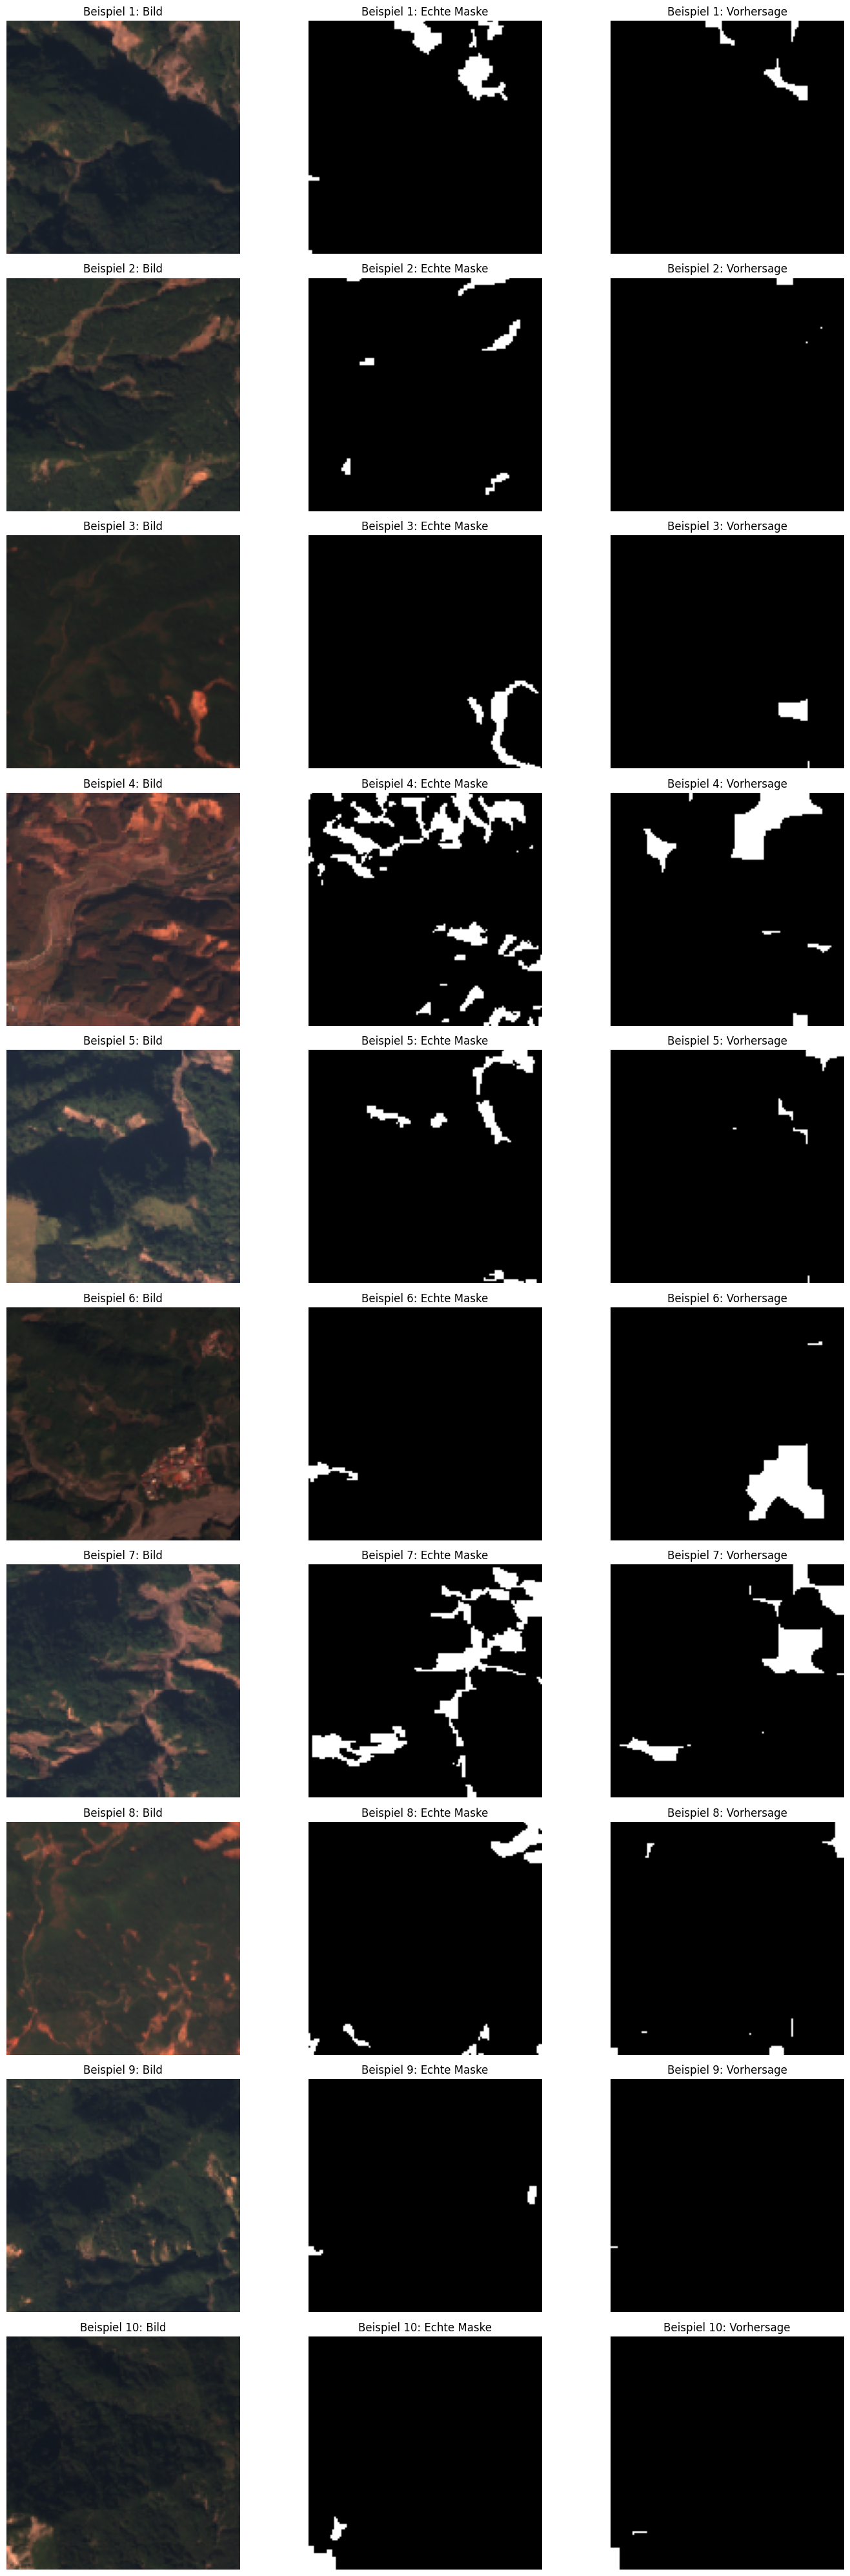

In [251]:
# Angenommen, test_loader ist dein DataLoader für die Testdaten
test_images, test_masks = next(iter(test_loader))
test_images, test_masks = test_images.to(device), test_masks.to(device)

# Vorhersagen treffen
model.eval()  # Setze das Modell in den Evaluierungsmodus
with torch.no_grad():
    predictions = model(test_images)['out']
    _, preds = torch.max(predictions, dim=1)  # Finde die Klasse mit der höchsten Wahrscheinlichkeit

# Visualisiere das Bild, die echte Maske und die Vorhersage
fig, axs = plt.subplots(10, 3, figsize=(15, 40))  # 10 Reihen, 3 Spalten für 10 Bilder

for i in range(10):  # 10 Bilder
    axs[i, 0].imshow(test_images[i].permute(1,2,0).cpu().numpy(), cmap='gray')  # Beachten Sie, dass wir die Dimensionen ändern, um das Bild zu zeigen
    axs[i, 0].axis('off')
    axs[i, 0].set_title(f'Beispiel {i + 1}: Bild')

    axs[i, 1].imshow(test_masks[i].squeeze(0).cpu(), cmap='gray')
    axs[i, 1].axis('off')
    axs[i, 1].set_title(f'Beispiel {i + 1}: Echte Maske')

    axs[i, 2].imshow(preds[i].cpu(), cmap='gray')
    axs[i, 2].axis('off')
    axs[i, 2].set_title(f'Beispiel {i + 1}: Vorhersage')

plt.tight_layout()
plt.show()


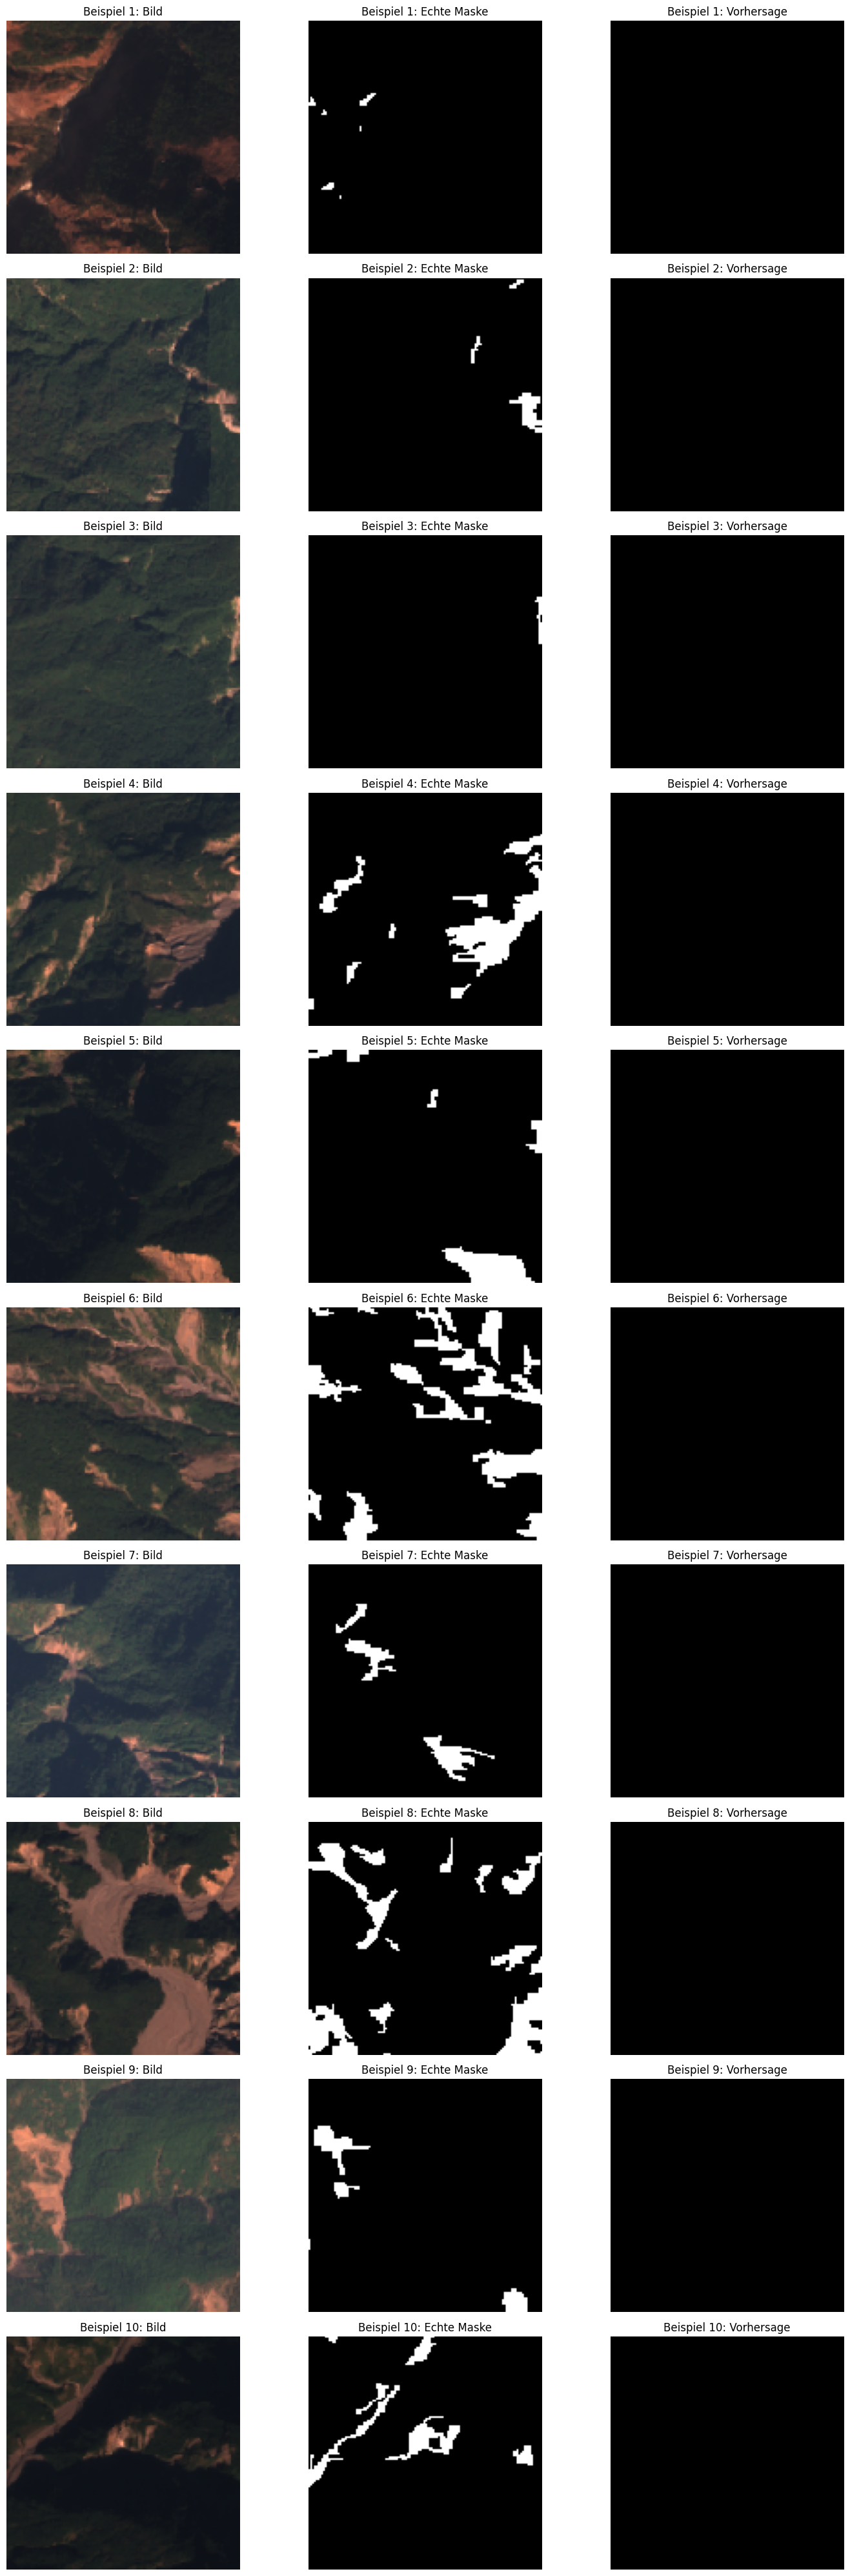

In [ ]:
# Angenommen, test_loader ist dein DataLoader für die Testdaten
train_images, train_masks = next(iter(train_loader))
train_images, train_masks = train_images.to(device), train_masks.to(device)

# Vorhersagen treffen
model.eval()  # Setze das Modell in den Evaluierungsmodus
with torch.no_grad():
    predictions = model(train_images)['out']
    _, preds = torch.max(predictions, dim=1)  # Finde die Klasse mit der höchsten Wahrscheinlichkeit

# Visualisiere das Bild, die echte Maske und die Vorhersage
fig, axs = plt.subplots(10, 3, figsize=(15, 40))  # 10 Reihen, 3 Spalten für 10 Bilder

for i in range(10):  # 10 Bilder
    axs[i, 0].imshow(train_images[i].permute(1,2,0).cpu().numpy(), cmap='gray')  # Beachten Sie, dass wir die Dimensionen ändern, um das Bild zu zeigen
    axs[i, 0].axis('off')
    axs[i, 0].set_title(f'Beispiel {i + 1}: Bild')

    axs[i, 1].imshow(train_masks[i].squeeze(0).cpu(), cmap='gray')
    axs[i, 1].axis('off')
    axs[i, 1].set_title(f'Beispiel {i + 1}: Echte Maske')

    axs[i, 2].imshow(preds[i].cpu(), cmap='gray')
    axs[i, 2].axis('off')
    axs[i, 2].set_title(f'Beispiel {i + 1}: Vorhersage')

plt.tight_layout()
plt.show()
